In [5]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

import joblib

Load the dataset and check its shape.

In [6]:
heart = pd.read_csv('heart_failure_clinical_records_dataset.csv')
print(heart.shape)
heart.head(2)

(299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1


In [7]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')

In [8]:
print_unique(heart)

age 
 [40.    41.    42.    43.    44.    45.    46.    47.    48.    49.
 50.    51.    52.    53.    54.    55.    56.    57.    58.    59.
 60.    60.667 61.    62.    63.    64.    65.    66.    67.    68.
 69.    70.    72.    73.    75.    77.    78.    79.    80.    81.
 82.    85.    86.    87.    90.    94.    95.   ] 

anaemia 
 [0 1] 

creatinine_phosphokinase 
 [  23   30   47   52   53   54   55   56   57   58   59   60   61   62
   63   64   66   68   69   70   72   75   76   78   80   81   84   86
   88   90   91   92   93   94   95   96   97   99  101  102  103  104
  109  110  111  112  113  115  118  119  121  122  123  124  125  127
  128  129  130  131  132  133  135  143  144  145  146  148  149  151
  154  156  157  159  160  161  166  167  168  170  171  176  180  185
  190  191  193  196  198  200  203  207  211  212  213  220  224  231
  232  233  235  244  245  246  248  249  250  253  257  258  260  270
  280  281  291  292  298  305  308  315  318  320  326 

The data above shows that the target type is binary. And both of binary and numerical features exist.

In [9]:
def snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

In [10]:
snapshot = snapshot(heart)
snapshot

,n_unique,dtype,n_missing,pct_missing
age,47,float64,0,0.0
anaemia,2,int64,0,0.0
creatinine_phosphokinase,208,int64,0,0.0
diabetes,2,int64,0,0.0
ejection_fraction,17,int64,0,0.0
high_blood_pressure,2,int64,0,0.0
platelets,176,float64,0,0.0
serum_creatinine,40,float64,0,0.0
serum_sodium,27,int64,0,0.0
sex,2,int64,0,0.0


Binary and numerical features are to be derived using the table above.

In [11]:
bina = snapshot[snapshot['n_unique'] == 2].index.drop('DEATH_EVENT')
num = snapshot[snapshot['n_unique'] != 2].index

In [12]:
heart['DEATH_EVENT'] = heart['DEATH_EVENT'].astype(str)

In [15]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    print(f"The ratio of quantity of label '1' samples to label '0' samples is {round(df[col].value_counts()[1]/df[col].value_counts()[0], 2)}")
    plt.show()

The ratio of quantity of label '1' samples to label '0' samples is 0.47


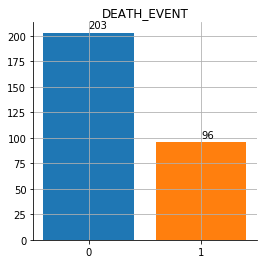

In [16]:
plot_single_categorical(heart, 'DEATH_EVENT')

The graph above shows that the dataset includes less samples with target label '1' than the ones with label '0' with quantity of label '1' samples being half of the other one's.

In [12]:
def scatter_fea_corr_classif_targ(df, features, target):
    corr = df[features].corr()
    n_features = len(features)
    n_sub_figs = (n_features * n_features - n_features) / 2
    if n_sub_figs < 4:
        nrows = 1
        ncols = n_sub_figs
        fig = plt.figure(figsize = (ncols * 3.75, 3))
    else:
        nrows =  math.ceil(n_sub_figs / 4)
        ncols = 4
        fig = plt.figure(figsize = (15, nrows * 3))
    
    m = 1
    for col in features:
        col_index = features.index(col)
        i = 1
        while (col_index + i) <= (n_features - 1):
            corr_val = 0
            ax = fig.add_subplot(nrows, ncols, m)
            ax = sns.scatterplot(x = col, y = features[col_index + i], hue = target, data = df)
            corr_val = round(corr.loc[col, features[col_index + i]], 2)
            plt.title(corr_val)
            
            i += 1
            m += 1
        if col_index == 0:
            break
    plt.tight_layout()
    plt.show()

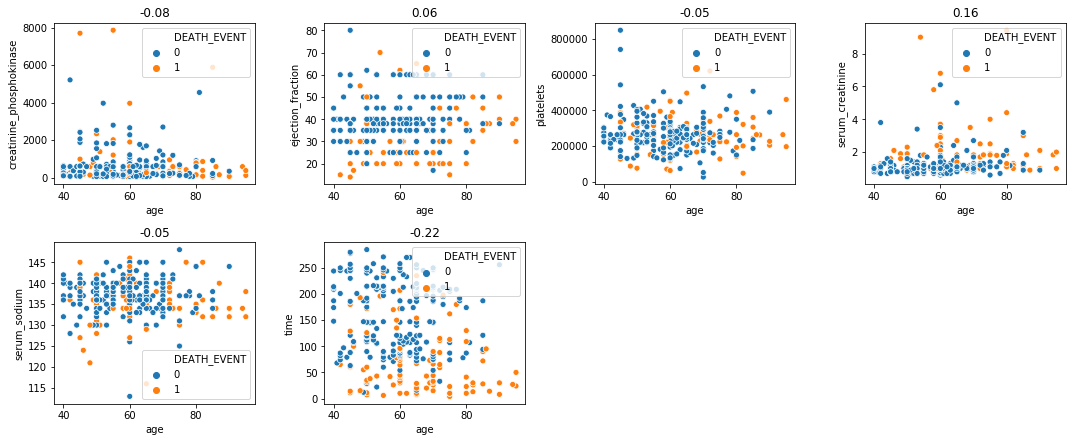

In [13]:
scatter_fea_corr_classif_targ(heart, num.tolist(), 'DEATH_EVENT')

the graphs above shows how the numerical features play in separating the target. 
It turns out that the samples could not be clustered by any numerical feature alone. 
It seems that none of those features is able to play a significant role in separating target.
And ouliers exist in the dataset.

In [30]:
heart['DEATH_EVENT'] = heart['DEATH_EVENT'].astype(int)

In [29]:
def feat_significance(X, y, n_feat_data_type, num):
    mi_df = pd.DataFrame(mutual_info_classif(X, y, random_state = 42), index = X.columns, columns = ['score'])
    mi_df = mi_df.sort_values(by = 'score', ascending = False)
    
    def color_cell(s):    
        background = []
        for i in range(len(s.index)):
            if s.index[i] in num:
                background.append('background-color: yellow')
            else:
                background.append('')
        return background
    
    if n_feat_data_type == 1:
        return mi_df
    else:
        return mi_df.style.apply(color_cell, axis = 0)

In [31]:
feat_sig = feat_significance(heart.drop('DEATH_EVENT', axis = 1), heart['DEATH_EVENT'], 2, num)
feat_sig

,score
time,0.240798
serum_creatinine,0.076126
ejection_fraction,0.061117
age,0.047854
creatinine_phosphokinase,0.030779
serum_sodium,0.021283
smoking,0.016590
high_blood_pressure,0.009862
anaemia,0.000000
diabetes,0.000000


The table above tells the order by which all of the features are ranked descendingly by significance.
The yellow cells correspond to the numerical features while the others show the binary features.
The most significant one is 'time' with score being '0.24'

In [18]:
def get_mean_std(df):
    mean_col = pd.DataFrame(df.mean(), columns = ['mean'])
    std_col = pd.DataFrame(df.std(), columns = ['std'])
    mean_plus_std = mean_col.join(std_col)
    return mean_plus_std

In [19]:
get_mean_std(heart[num])

,mean,std
age,60.833893,11.894809
creatinine_phosphokinase,581.839465,970.287881
ejection_fraction,38.083612,11.834841
platelets,263358.029264,97804.236869
serum_creatinine,1.393880,1.034510
serum_sodium,136.625418,4.412477
time,130.260870,77.614208


The data above shows that the data range spreads widely among numerical features, so the operation of 'scale' is expected to be used.

In [23]:
X_scaled = pd.DataFrame(scale(heart[num]), columns = num).join(heart[bina])

In [24]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)

In [25]:
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [34]:
def num_feat_perform(algorithm, feat_ordered, X_ordered, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X_ordered.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_multi_alg(alg_dict, feat_ordered, X_ordered, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X_ordered, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

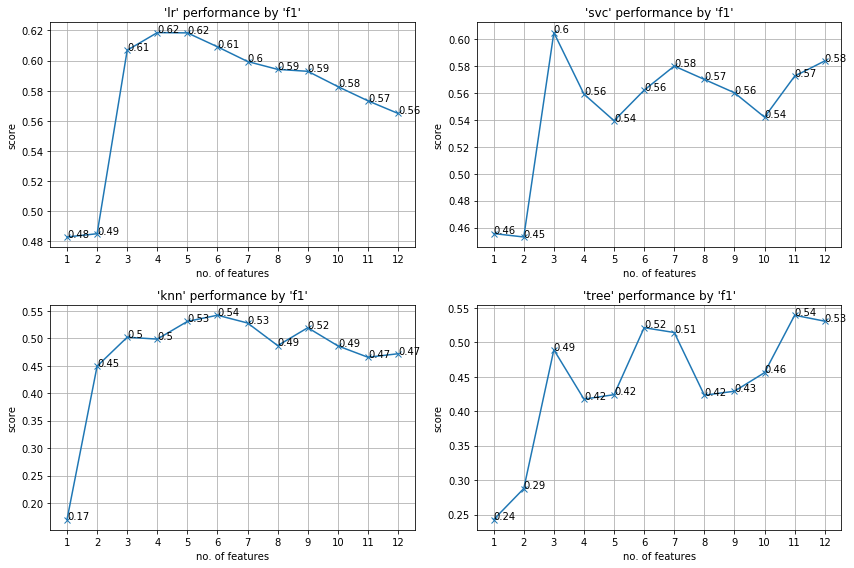

In [35]:
num_feat_multi_alg(alg_dict, feat_sig.index, X_scaled[feat_sig.index], heart['DEATH_EVENT'], 'f1')

In [36]:
feat_sig.index[0:4]

Index(['time', 'serum_creatinine', 'ejection_fraction', 'age'], dtype='object')

In [38]:
train_sizes = np.linspace(start = 10, stop = X_scaled.shape[0] * 0.8, num = 6, dtype = int)

In [39]:
def plot_learning_curve(train_scores, test_scores):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

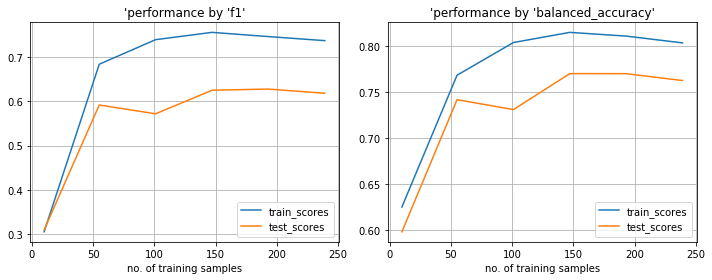

In [42]:
two_metric_graph(lr, X_scaled[feat_sig.index[0:4]], heart['DEATH_EVENT'])

In [43]:
lr.fit(X_scaled[feat_sig.index[0:4]], heart['DEATH_EVENT'])
joblib.dump(lr, 'lr.joblib')

['lr.joblib']